## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета FOOD 101

In [81]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

In [82]:
test_ds

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [83]:
train_ds

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

## Визуализация датасета FOOD 101

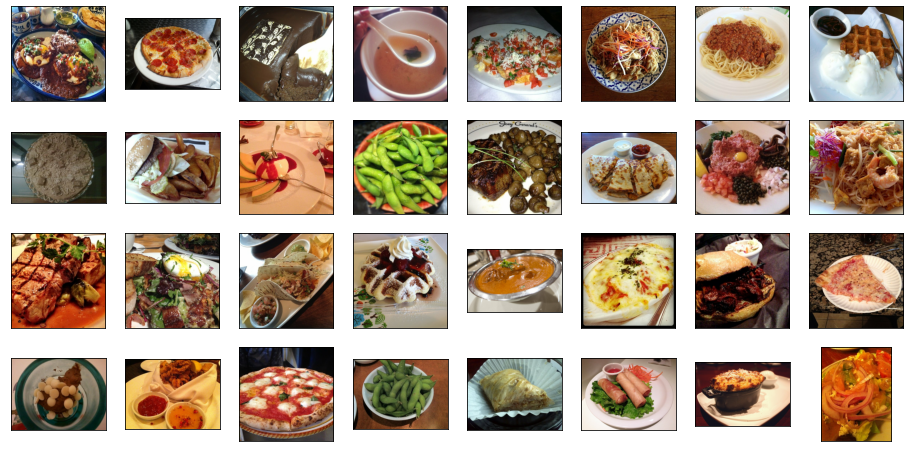

In [84]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [85]:
INP_SIZE = 160
NUM_EPOCHS = 10
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)//127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [86]:
test_ds

<BatchDataset shapes: ((128, 160, 160, 3), (128,)), types: (tf.float32, tf.int64)>

In [87]:
train_ds

<BatchDataset shapes: ((32, 160, 160, 3), (32,)), types: (tf.float32, tf.int64)>

# Подготовка модели CNN

In [88]:
EXP_NAME = 'transfer'
base_model = tf.keras.applications.inception_v3.InceptionV3(
input_shape=(INP_SIZE, INP_SIZE, 3),
include_top=False,
weights='imagenet'
)
base_model.trainable = True # Fine-tuning весов предобученной модели
    # base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='relu'),
    #tf.keras.layers.Dropout(0.2)
])


## Подготовка к обучению

In [89]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Model Summary

In [90]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 101)               206949    
Total params: 22,009,733
Trainable params: 21,975,301
Non-trainable params: 34,432
_________________________________________________________________


## Обучение модели

In [91]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/10


ValueError: ignored

In [ ]:
Помогите, пожалуйста, понять, как исправить эту ошибку. 

## Оценка качества модели

In [ ]:
%%time

model.evaluate(test_ds)

     18/Unknown - 5s 254ms/step - loss: 0.0794 - accuracy: 0.9887CPU times: user 7.3 s, sys: 669 ms, total: 7.97 s
Wall time: 4.64 s


[0.07940421269874302, 0.9887153]

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2796), started 0:18:59 ago. (Use '!kill 2796' to kill it.)

<IPython.core.display.Javascript object>

## Запуск предсказания на нашем изображении

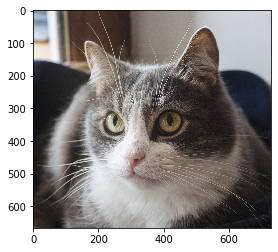

In [ ]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/dl-demo/master/catdog/img/image.png

img = imageio.imread('image.png', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [ ]:
pred = model(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))

Prediction: cat
